In [1]:
import pandas as pd
import numpy as np
from app.modules import prep_data, train_model, select_features, build_dset, build_LSTM, build_BLSTM, build_AttentiveBLSTM
from app.modules import gen_test_df, gen_importance_df
from app.modules.lstm import save_model, series_to_supervised, load_model, get_lime_df

from app.api import GoogleTrends
import datetime as dt
import time

## PLOTS

In [2]:
from turtle import width
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# To load filtered test predictions
def filter_test_df(test_df, ticker, model_id, pred_scope):

    test_df = test_df.query('Scope==@pred_scope & Ticker==@ticker & Model==@model_id')
    test_df = test_df[['Observed', 'Predicted']]

    return test_df.sort_index()


def plot_model_test(filtered_df: pd.DataFrame, px_theme: str ='plotly_dark'):

    fig = px.line(
            filtered_df,
            x=filtered_df.index, 
            y=filtered_df.columns,
            template=px_theme,
            labels={
                    'variable': ''
                },
            )
    fig.update_layout(
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )
    fig.update_yaxes(title_text = 'Close Price')
    fig.update_layout(
        yaxis_tickformat = '$',
        title={
            #'text': "Model Performance",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
            #family="Courier New, monospace",
            size=25)
            },
        )
    fig.update_traces(hovertemplate='%{y:$,.2f}')
    fig.update_layout(hovermode="x unified")

    fig.update_xaxes(
        title_text = 'Date',
        rangeslider_visible = True
        )
    fig.update_layout(width=750, height=500)
    return fig


def plot_importance(importance_df: pd.DataFrame, px_theme: str ='plotly_dark'):

    fig = go.Figure()
    fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='DarkGrey')

    metrics_list = list(importance_df['Metric'].unique())

    for metric in metrics_list:
        vis = metric == 'mae'
        mdf = importance_df[importance_df['Metric']==metric]

        mdf = mdf.sort_values('Importance').tail(5)
        fig.add_trace(
            go.Bar(
                orientation='h', 
                x = mdf['Importance'],
                y = mdf['Feature'],
                name = metric, 
                visible=vis
            )
        )
                
    buttons = []

    for i, metric in enumerate(metrics_list):
        args = [False] * len(metrics_list)
        args[i] = True
        
        button = dict(
                    label = metric.upper(),
                    method = "update",
                    args=[{"visible": args}])
        
        buttons.append(button)
        
    fig.update_layout(
        updatemenus=[dict(
                        active=0,
                        type="buttons",
                        direction = "left",
                        buttons=buttons,
                        x = 1,
                        y = 1,
                        xanchor = 'left',
                        yanchor = 'bottom'
                    )], 
        autosize=True,
    )
    fig.update_layout(
        title={
            'text': "Error Perturbation",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
            #family="Courier New, monospace",
            size=25
            )
            },
        template=px_theme
    )

    fig.update_yaxes(tickmode='linear')
    #fig.update_layout(updatemenus=[dict(font=dict(color='gray',), bgcolor='black')])
    fig.update_traces(marker_color='rgba(50, 171, 96, 0.6)')
    fig.update_layout(width=750, height=500)

    return fig

In [3]:
"""COINS_SELECTION = [
    'BTC',
    'ETH',
    'NMC', 
    'FTC', 
    'PPC', 
    'LTC',
]
dset = build_dset(coins_list=COINS_SELECTION, gtrends=True)"""

"COINS_SELECTION = [\n    'BTC',\n    'ETH',\n    'NMC', \n    'FTC', \n    'PPC', \n    'LTC',\n]\ndset = build_dset(coins_list=COINS_SELECTION, gtrends=True)"

## Prepare Data

- Discard redundant features using simple rule based on correlation.
- Scale features with MinMaxScaler
- Reframe the data structure and reshape it to (n_samples, n_timesteps, n_features) such that every sample is a matrix
- Split, we try to use last year as test set, but if we have less data available it could be 6 months for some cryptocurrencies.

## Feature Selection

In [4]:
# Read easier than building everytime
data = pd.read_csv('hist_data_all.csv', parse_dates=['Date'], index_col='Date')
# Build the dataset of pre-selected coins
dsets = {}
for t in list(data.Ticker.unique()):
  df = data.query('Ticker==@t')
  dsets[t] = df[['High', 'Low', 'Volume', 'FVX', 'TNX', 'TYX', 'Gtrend', 'Close']]
dsets['BTC-USD']

,High,Low,Volume,FVX,TNX,TYX,Gtrend,Close
Date,,,,,,,,
2014-09-17,468.174011,452.421997,21056800,1.804,2.600,3.364,47.000,457.334015
2014-09-18,456.859985,413.104004,34483200,1.841,2.629,3.359,47.000,424.440002
2014-09-19,427.834991,384.532013,37919700,1.819,2.587,3.299,53.000,394.795990
2014-09-20,423.295990,389.882996,36863600,1.819,2.587,3.299,46.000,408.903992
2014-09-21,412.425995,393.181000,26580100,1.819,2.587,3.299,48.000,398.821014
...,...,...,...,...,...,...,...,...
2022-06-24,21472.917969,20777.511719,24957784918,3.175,3.125,3.257,47.000,21231.656250
2022-06-25,21520.914062,20964.585938,18372538715,3.175,3.125,3.257,41.000,21502.337891
2022-06-26,21783.724609,21016.269531,18027170497,3.175,3.125,3.257,40.000,21027.294922


In [5]:
# An example of feature correlation
dsets['LTC-USD'].corr()

,High,Low,Volume,FVX,TNX,TYX,Gtrend,Close
High,1.000000,0.995395,0.550188,-0.030481,-0.079392,-0.228810,0.156088,0.997946
Low,0.995395,1.000000,0.532839,-0.027295,-0.081217,-0.236278,0.141117,0.997499
Volume,0.550188,0.532839,1.000000,-0.445127,-0.491198,-0.544325,0.379015,0.544276
FVX,-0.030481,-0.027295,-0.445127,1.000000,0.963404,0.846541,-0.223486,-0.030056
TNX,-0.079392,-0.081217,-0.491198,0.963404,1.000000,0.951779,-0.254424,-0.080994
TYX,-0.228810,-0.236278,-0.544325,0.846541,0.951779,1.000000,-0.260868,-0.232595
Gtrend,0.156088,0.141117,0.379015,-0.223486,-0.254424,-0.260868,1.000000,0.150444
Close,0.997946,0.997499,0.544276,-0.030056,-0.080994,-0.232595,0.150444,1.000000


In [6]:
# Apply simple feature selection
select_features(dsets)
dsets['BTC-USD']

,Volume,TYX,Gtrend,Close
Date,,,,
2014-09-17,21056800,3.364,47.000,457.334015
2014-09-18,34483200,3.359,47.000,424.440002
2014-09-19,37919700,3.299,53.000,394.795990
2014-09-20,36863600,3.299,46.000,408.903992
2014-09-21,26580100,3.299,48.000,398.821014
...,...,...,...,...
2022-06-24,24957784918,3.257,47.000,21231.656250
2022-06-25,18372538715,3.257,41.000,21502.337891
2022-06-26,18027170497,3.257,40.000,21027.294922


In [8]:
timesteps = 60
prep_dsets = {
    coin: prep_data(df, timesteps) for coin, df in dsets.items()
}

(2849, 4)
(1698, 4)
(2849, 4)
(2849, 4)
(2849, 4)
(2849, 4)


# BTC - Bitcoin

In [121]:
cc = 'BTC-USD'
timesteps = 60
scope = '1 day ahead'
ticker = cc[:3]
X_train, y_train, X_test, y_test, xscaler, yscaler, test_dates = prep_dsets[cc]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2424, 60, 4) (2424,) (365, 60, 4) (365,)


## LSTM Neural Network Architectures

We defined custom architectures for the long short term memory neural networks. Defined as Keras Functional models, they take a series of parameters to customize them in terms of number of Recurrent Neural Layers, the number of units for each one of them, the number of units in the final dense layer, how many steps into the future of the target we are forecasting, and some other parameters such as dropout, learning rate and model name. We have considered 3 types of recurrent neural networks here: a simple LSTM, a bidirectional LSTM and a bidirectional LSTM with attention.

Later, we test different versions of these models, compare them and choose one or two to make it available for the final user.

We tried different combinations of parameters such as the number of lags to include and hyperparameters. We arrived to a couple of base models that will vary in small details across coins and prediction scopes.

## LSTM Model

In [122]:
model_id = 'Deep Learning LSTM'
lstm_model = build_LSTM(
                    (60, 4),
                    num_rnns=2,
                    dim_rnn=100, 
                    dense_units=100, 
                    drop=False, 
                    drop_rate=0.1
                    )
lstm_model = load_model(lstm_model, 'BTC_LSTM_60_lags_4_fts', 'models/')
lstm_tdf = gen_test_df(lstm_model, X_test, y_test, yscaler, ticker='BTC', test_dates=test_dates, lags=timesteps, model_id=model_id, pred_scope=scope)
lstm_tdf = filter_test_df(lstm_tdf, 'BTC', model_id, scope)
plot_model_test(lstm_tdf).show()
lstm_idf = gen_importance_df(lstm_model, dsets['BTC-USD'], timesteps, 'BTC', model_id, scope)
plot_importance(lstm_idf)

12/12 [==============================] - 1s 33ms/step


(2849, 4)


Epoch 1/100
2424/2424 - 53s - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0025 - val_mse: 0.0025 - 53s/epoch - 22ms/step
Epoch 2/100
2424/2424 - 49s - loss: 9.2156e-04 - mse: 9.2156e-04 - val_loss: 0.0080 - val_mse: 0.0080 - 49s/epoch - 20ms/step
Epoch 3/100
2424/2424 - 49s - loss: 7.8157e-04 - mse: 7.8157e-04 - val_loss: 0.0015 - val_mse: 0.0015 - 49s/epoch - 20ms/step
Epoch 4/100
2424/2424 - 49s - loss: 6.9793e-04 - mse: 6.9793e-04 - val_loss: 0.0019 - val_mse: 0.0019 - 49s/epoch - 20ms/step
Epoch 5/100
2424/2424 - 49s - loss: 6.5628e-04 - mse: 6.5628e-04 - val_loss: 0.0014 - val_mse: 0.0014 - 49s/epoch - 20ms/step
Epoch 6/100
2424/2424 - 50s - loss: 4.8067e-04 - mse: 4.8067e-04 - val_loss: 0.0029 - val_mse: 0.0029 - 50s/epoch - 21ms/step
Epoch 7/100
2424/2424 - 49s - loss: 4.9867e-04 - mse: 4.9867e-04 - val_loss: 0.0014 - val_mse: 0.0014 - 49s/epoch - 20ms/step
Epoch 8/100
2424/2424 - 50s - loss: 3.9175e-04 - mse: 3.9175e-04 - val_loss: 0.0044 - val_mse: 0.0044 - 50s/epoch - 20ms/step


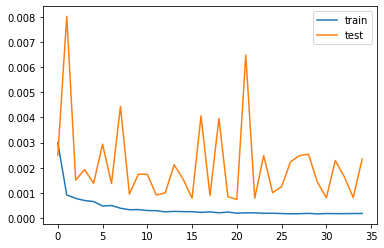

12/12 [==============================] - 1s 25ms/step


(2849, 4)


In [14]:
model_id = 'Deep Learning LSTM'
lstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_LSTM,
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=100, 
                                                                        dense_units=100, 
                                                                        drop=False, 
                                                                        drop_rate=0.1,
                                                                    ),
                                                                    batch_size=1,
                                                                    n_epochs=100,
                                                                    early_stop=True,
                                                                    patience=30,
                                                                    save=True
                                                                )
lstm_model = load_model(lstm_model, 'BTC_LSTM_60_lags_4_fts', '/models/')
lstm_tdf = gen_test_df(lstm_model, X_test, y_test, yscaler, ticker='BTC', test_dates=test_dates, lags=timesteps, model_id=model_id, pred_scope=scope)
lstm_tdf = filter_test_df(lstm_tdf, 'BTC', model_id, scope)
plot_model_test(lstm_tdf).show()
lstm_idf = gen_importance_df(lstm_model, dsets['BTC-USD'], timesteps, 'BTC', model_id, scope)
plot_importance(lstm_idf)

## BLSTM

Epoch 1/100
2424/2424 - 64s - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0045 - val_mse: 0.0045 - 64s/epoch - 26ms/step
Epoch 2/100
2424/2424 - 60s - loss: 8.7892e-04 - mse: 8.7892e-04 - val_loss: 0.0054 - val_mse: 0.0054 - 60s/epoch - 25ms/step
Epoch 3/100
2424/2424 - 59s - loss: 7.2312e-04 - mse: 7.2312e-04 - val_loss: 0.0028 - val_mse: 0.0028 - 59s/epoch - 24ms/step
Epoch 4/100
2424/2424 - 58s - loss: 6.1978e-04 - mse: 6.1978e-04 - val_loss: 0.0089 - val_mse: 0.0089 - 58s/epoch - 24ms/step
Epoch 5/100
2424/2424 - 60s - loss: 4.7806e-04 - mse: 4.7806e-04 - val_loss: 0.0026 - val_mse: 0.0026 - 60s/epoch - 25ms/step
Epoch 6/100
2424/2424 - 60s - loss: 4.5063e-04 - mse: 4.5063e-04 - val_loss: 0.0050 - val_mse: 0.0050 - 60s/epoch - 25ms/step
Epoch 7/100
2424/2424 - 61s - loss: 4.0324e-04 - mse: 4.0324e-04 - val_loss: 0.0029 - val_mse: 0.0029 - 61s/epoch - 25ms/step
Epoch 8/100
2424/2424 - 59s - loss: 3.2521e-04 - mse: 3.2521e-04 - val_loss: 0.0033 - val_mse: 0.0033 - 59s/epoch - 24ms/step


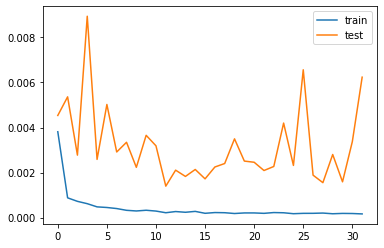

12/12 [==============================] - 1s 12ms/step


(2849, 4)


In [24]:
model_id = 'Bidirectional LSTM'
blstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_BLSTM, 
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=16, 
                                                                        dense_units=50, 
                                                                        drop=False,
                                                                        drop_rate=0.5
                                                                    ),
                                                                    n_epochs=100,
                                                                    early_stop=True,
                                                                    patience=20,
                                                                    save=True
                                                                )
blstm_tdf = gen_test_df(
    blstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    ticker='BTC', 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
blstm_tdf = filter_test_df(
    blstm_tdf, 
    'BTC', 
    model_id, 
    scope
    )
plot_model_test(blstm_tdf).show()
blstm_idf = gen_importance_df(
    blstm_model, 
    dsets['BTC-USD'], 
    timesteps, 
    'BTC', 
    model_id, 
    scope
    )
plot_importance(blstm_idf)

In [44]:
preds_df = pd.concat([lstm_tdf, blstm_tdf])
preds_df.to_csv('./models/predictions.csv', index=True)

imp_df = pd.concat([lstm_idf, blstm_idf])
imp_df.to_csv('./models/ft_importance.csv', index=False)

## Attentive BLSTM

In [ ]:
model_id = 'Attentive Bidirectional LSTM'
ablstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_AttentiveBLSTM,
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=32,
                                                                        drop=False, 
                                                                        drop_rate=0.5,
                                                                        suffix='5RNN_d50'
                                                                    ),
                                                                    n_epochs=30,
                                                                    early_stop=True,
                                                                    patience=10    
                                                                )
ablstm_tdf = gen_test_df(
    ablstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    ticker='BTC', 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
ablstm_tdf = filter_test_df(
    ablstm_tdf, 
    'BTC', 
    model_id, 
    scope
    )
plot_model_test(ablstm_tdf).show()
ablstm_idf = gen_importance_df(
    ablstm_model, 
    dsets['BTC-USD'], 
    timesteps, 
    'BTC', 
    model_id, 
    scope
    )
plot_importance(ablstm_idf)

In [13]:
bblstm_model = build_BLSTM(
    (60, 4),
    num_rnns=2,
    dim_rnn=16, 
    dense_units=50, 
    drop=False,
    drop_rate=0.5
)
bblstm_model = load_model(bblstm_model, 'BTC_Bidirectional_LSTM_60_lags_4_fts', 'models/')    
bblstm_idf = gen_importance_df(bblstm_model, dsets['BTC-USD'], timesteps, 'BTC', 'Bidirectional LSTM', scope)
plot_importance(bblstm_idf)                                                

(2849, 4)


## Explainable Forecast

We use LIME methodology to make our deep learning models more interpretable. Here, we get the most relevant features at different time steps and their contributions for a single sample prediction. Below, we get the top 10 features contributing to the final prediction for a recent date. This will let us understand the most relevant factors and their influence on the price at different points of time.

**EXPLICAR MEJOR LIME!!**

In [ ]:
%%capture
%pip install lime

In [98]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.RecurrentTabularExplainer(
    X_train,
    feature_names=list(dsets['BTC-USD'].columns),
    verbose=True,
    mode='regression',
    discretize_continuous=False
    )
i = np.argmin(y_test.reshape(365))
exp = explainer.explain_instance(X_test[i], bblstm_model.predict)
exp.show_in_notebook()

157/157 [==============================] - 2s 12ms/step
Intercept 0.07949676992320218
Prediction_local [0.19252553]
Right: 0.19942684


In [70]:
lime_df = pd.DataFrame(exp.as_list(), columns=['Feature', 'LIME Weight'])
px.bar(
    lime_df, 
    x='LIME Weight', 
    y='Feature', 
    orientation='h', 
    color='LIME Weight', 
    template='plotly_white',
    title='LIME - Feature Effect on Close t+1',
    color_continuous_scale='viridis'
    )

In [101]:
(yscaler.inverse_transform(lime_df['LIME Weight'].abs().values.reshape(-1,1))[:,0] * (lime_df['LIME Weight'].values//lime_df['LIME Weight'].abs().values)).sum()

7736.427088188967

In [106]:
lime_df['LIME Weight'].sum() + exp.intercept[0]

0.18901391957248537

We get the lime estimate of feature contribution to the cryptocurrency price for each one of the test samples, giving us the top 10 features and their direct effect on the forecast. Thus, making the model explainable across time.

In [133]:
def get_lime_df(model, model_id, X_train, X_test, dsets, test_dates, ticker, scope, yscaler):

    explainer = lime.lime_tabular.RecurrentTabularExplainer(
                                            X_train,
                                            feature_names=list(dsets[ticker + '-USD'].columns),
                                            verbose=True,
                                            mode='regression',
                                            discretize_continuous=False
                                            )

    lime_dfs = []
    for i in range(len(test_dates)):
        exp = explainer.explain_instance(X_test[i], model.predict)
        lime_df = pd.DataFrame(exp.as_list(), columns=['Feature', 'LIME Weight'])
        lime_df['Predicted Close t+'+scope[0]] = yscaler.inverse_transform(lime_df['LIME Weight'].abs().values.reshape(-1,1))[:,0] * (lime_df['LIME Weight'].values//lime_df['LIME Weight'].abs().values)
        lime_df['Date'] = test_dates[i]
        lime_df['Model'] = model_id
        lime_df['Ticker'] = ticker
        lime_df['Scope'] = scope
        lime_dfs.append(lime_df)
    lime_df = pd.concat(lime_dfs)
    lime_df['LIME Weight'] = yscaler.inverse_transform(lime_df['LIME Weight'].values.reshape(-1,1))
    lime_df.rename(columns={'Date': 'Date_dt'}, inplace=True)
    lime_df['Date'] = lime_df['Date_dt'].dt.date.apply(lambda x: str(x))
    return lime_df

In [123]:
lstm_ldf = get_lime_df(lstm_model, 'Deep Learning LSTM', X_train, X_test, dsets, test_dates, ticker, scope, yscaler)

157/157 [==============================] - 5s 32ms/step
Intercept 0.12316798857208984
Prediction_local [0.40164299]
Right: 0.48853472
157/157 [==============================] - 5s 34ms/step
Intercept 0.12308562672142696
Prediction_local [0.41208688]
Right: 0.49539533
157/157 [==============================] - 5s 34ms/step
Intercept 0.12284063433688004
Prediction_local [0.40693295]
Right: 0.4916888
157/157 [==============================] - 5s 32ms/step
Intercept 0.12324066531098729
Prediction_local [0.403748]
Right: 0.48858064
157/157 [==============================] - 5s 34ms/step
Intercept 0.12301843807374165
Prediction_local [0.4015109]
Right: 0.48916122
157/157 [==============================] - 5s 34ms/step
Intercept 0.1230201921760399
Prediction_local [0.40229143]
Right: 0.4932639
157/157 [==============================] - 5s 32ms/step
Intercept 0.12288040729174983
Prediction_local [0.39624855]
Right: 0.48988608
157/157 [==============================] - 5s 32ms/step
Intercept 0.

In [78]:
blstm_ldf = get_lime_df(bblstm_model, 'Bidirectional LSTM',X_train, X_test, dsets, test_dates, ticker, scope, yscaler)

157/157 [==============================] - 2s 11ms/step
Intercept 0.07972324957707544
Prediction_local [0.42496342]
Right: 0.4707762
157/157 [==============================] - 2s 11ms/step
Intercept 0.07973124639787957
Prediction_local [0.43679179]
Right: 0.475101
157/157 [==============================] - 2s 11ms/step
Intercept 0.080234700473186
Prediction_local [0.42083084]
Right: 0.46523824
157/157 [==============================] - 2s 10ms/step
Intercept 0.08007218380546086
Prediction_local [0.41258729]
Right: 0.4610534
157/157 [==============================] - 2s 11ms/step
Intercept 0.07961358325153733
Prediction_local [0.41533765]
Right: 0.46535683
157/157 [==============================] - 2s 11ms/step
Intercept 0.07985403361099673
Prediction_local [0.41985777]
Right: 0.47555462
157/157 [==============================] - 2s 10ms/step
Intercept 0.07991760337440665
Prediction_local [0.41311825]
Right: 0.47160956
157/157 [==============================] - 2s 10ms/step
Intercept 0.

In [141]:
blstm_ldf['Date'] = blstm_ldf['Date'].dt.date.apply(lambda x: str(x))
#lime_all = pd.concat([lstm_ldf, blstm_ldf])
#lime_all.to_csv('./models/lime_weights.csv', index=False)

In [130]:
pd.read_csv('./models/lime_weights.csv')

,Feature,LIME Weight,Predicted Close t+1,Date_dt,Model,Ticker,Scope,Date
0,Close_t-1,1605.482966,1605.482966,2021-06-30,Deep Learning LSTM,BTC,1 day ahead,2021-06-30
1,Close_t-0,1554.365202,1554.365202,2021-06-30,Deep Learning LSTM,BTC,1 day ahead,2021-06-30
2,Close_t-2,1437.950205,1437.950205,2021-06-30,Deep Learning LSTM,BTC,1 day ahead,2021-06-30
3,Close_t-3,1193.524599,1193.524599,2021-06-30,Deep Learning LSTM,BTC,1 day ahead,2021-06-30
4,Close_t-4,971.324628,971.324628,2021-06-30,Deep Learning LSTM,BTC,1 day ahead,2021-06-30
...,...,...,...,...,...,...,...,...
7295,TYX_t-0,-116.004449,-472.210442,2022-06-28,Bidirectional LSTM,BTC,1 day ahead,2022-06-28
7296,TYX_t-1,9.014965,-347.191028,2022-06-28,Bidirectional LSTM,BTC,1 day ahead,2022-06-28
7297,Gtrend_t-0,37.066723,-319.139270,2022-06-28,Bidirectional LSTM,BTC,1 day ahead,2022-06-28
7298,Close_t-59,293.631683,293.631683,2022-06-28,Bidirectional LSTM,BTC,1 day ahead,2022-06-28


In [134]:
def plot_lime(lime_df):

    fig = px.bar(
        lime_df, 
        x='LIME Weight', 
        y='Feature',
        animation_frame='Date',
        orientation='h', 
        color='LIME Weight', 
        template='plotly_dark',
        title="LIME - Top Features' Effect on Close t+1",
        color_continuous_scale='viridis',
        )
    fig.update_layout(
            xaxis_tickformat = '$',
            title={
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font': dict(
                #family="Courier New, monospace",
                size=25)
                },
            )
    fig.update_traces(
        hovertemplate="<br>".join([
            "Feature: %{y}",
            "Contribution: $%{x:,.2f}"])
            )

    fig.show()

In [143]:
plot_lime(lstm_ldf)

In [142]:
plot_lime(blstm_ldf)

# ETH - Ethereum

#### Prepare Data and Take a look at Selected Features

In [9]:
cc = 'ETH-USD'
timesteps = 60
scope = '1 day ahead'
ticker = cc[:3]
X_train, y_train, X_test, y_test, xscaler, yscaler, test_dates = prep_dsets[cc]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1518, 60, 4) (1518,) (120, 60, 4) (120,)


In [10]:
dsets[cc]

,Volume,FVX,Gtrend,Close
Date,,,,
2017-11-09,893249984,2.003,26.000000,320.884003
2017-11-10,885985984,2.055,22.000000,299.252991
2017-11-11,842300992,2.055,19.000000,314.681000
2017-11-12,1613479936,2.055,20.000000,307.907990
2017-11-13,1041889984,2.072,20.000000,316.716003
...,...,...,...,...
2022-06-24,16981552654,3.175,46.000000,1226.844727
2022-06-25,12481946184,3.175,42.000000,1243.446899
2022-06-26,12096607824,3.175,40.000000,1199.831665


## LSTM

In [12]:
model_id = 'Deep Learning LSTM'
lstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_LSTM,
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=128, 
                                                                        dense_units=100, 
                                                                        drop=True, 
                                                                        drop_rate=0.3,
                                                                    ),
                                                                    batch_size=1,
                                                                    n_epochs=100,
                                                                    early_stop=True,
                                                                    patience=30,
                                                                    save=True
                                                                )
lstm_tdf = gen_test_df(
    lstm_model, 
    X_test, y_test, 
    yscaler, 
    ticker=ticker, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
lstm_tdf = filter_test_df(lstm_tdf, ticker, model_id, scope)
plot_model_test(lstm_tdf).show()
lstm_idf = gen_importance_df(lstm_model, dsets[cc], timesteps, ticker, model_id, scope)
plot_importance(lstm_idf)

Epoch 1/100
1518/1518 - 36s - loss: 4.8585 - mse: 4.8585 - val_loss: 0.0025 - val_mse: 0.0025 - 36s/epoch - 24ms/step
Epoch 2/100
1518/1518 - 35s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0071 - val_mse: 0.0071 - 35s/epoch - 23ms/step
Epoch 3/100


KeyboardInterrupt: 

### LIME Explainable

## BLSTM

In [ ]:
model_id = 'Bidirectional LSTM'
blstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_BLSTM, 
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=16, 
                                                                        dense_units=50, 
                                                                        drop=False,
                                                                        drop_rate=0.5
                                                                    ),
                                                                    n_epochs=100,
                                                                    early_stop=True,
                                                                    patience=20,
                                                                    save=True
                                                                )
blstm_tdf = gen_test_df(
    blstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    ticker=ticker, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
blstm_tdf = filter_test_df(
    blstm_tdf, 
    ticker, 
    model_id, 
    scope
    )
plot_model_test(blstm_tdf).show()
blstm_idf = gen_importance_df(
    blstm_model, 
    dsets[cc], 
    timesteps, 
    ticker, 
    model_id, 
    scope
    )
plot_importance(blstm_idf)

### LIME Explainable

In [ ]:
lstm_ldf = get_lime_df(lstm_model, 'Deep Learning LSTM', X_train, X_test, dsets, test_dates, ticker, scope, yscaler)
blstm_ldf = get_lime_df(lstm_model, 'Deep Learning LSTM', X_train, X_test, dsets, test_dates, ticker, scope, yscaler)
pd.concat([lstm_ldf, blstm_ldf]).to_csv('./models/other_tested/ETH_lime.csv', index=False)
pd.concat([lstm_idf, blstm_idf]).to_csv('./models/other_tested/ETH_fimp.csv', index=False)
pd.concat([lstm_tdf, blstm_tdf]).to_csv('./models/other_tested/ETH_preds.csv')

In [ ]:
plot_lime(lstm_ldf)
plot_lime(blstm_ldf)